In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Set some visualization styles
sns.set_style("whitegrid")
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=14, titlepad=10)

In [ ]:
base_dir = '/content/drive/MyDrive/Teeth-Classification/Teeth_Dataset'

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Testing')

Found 7 classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']



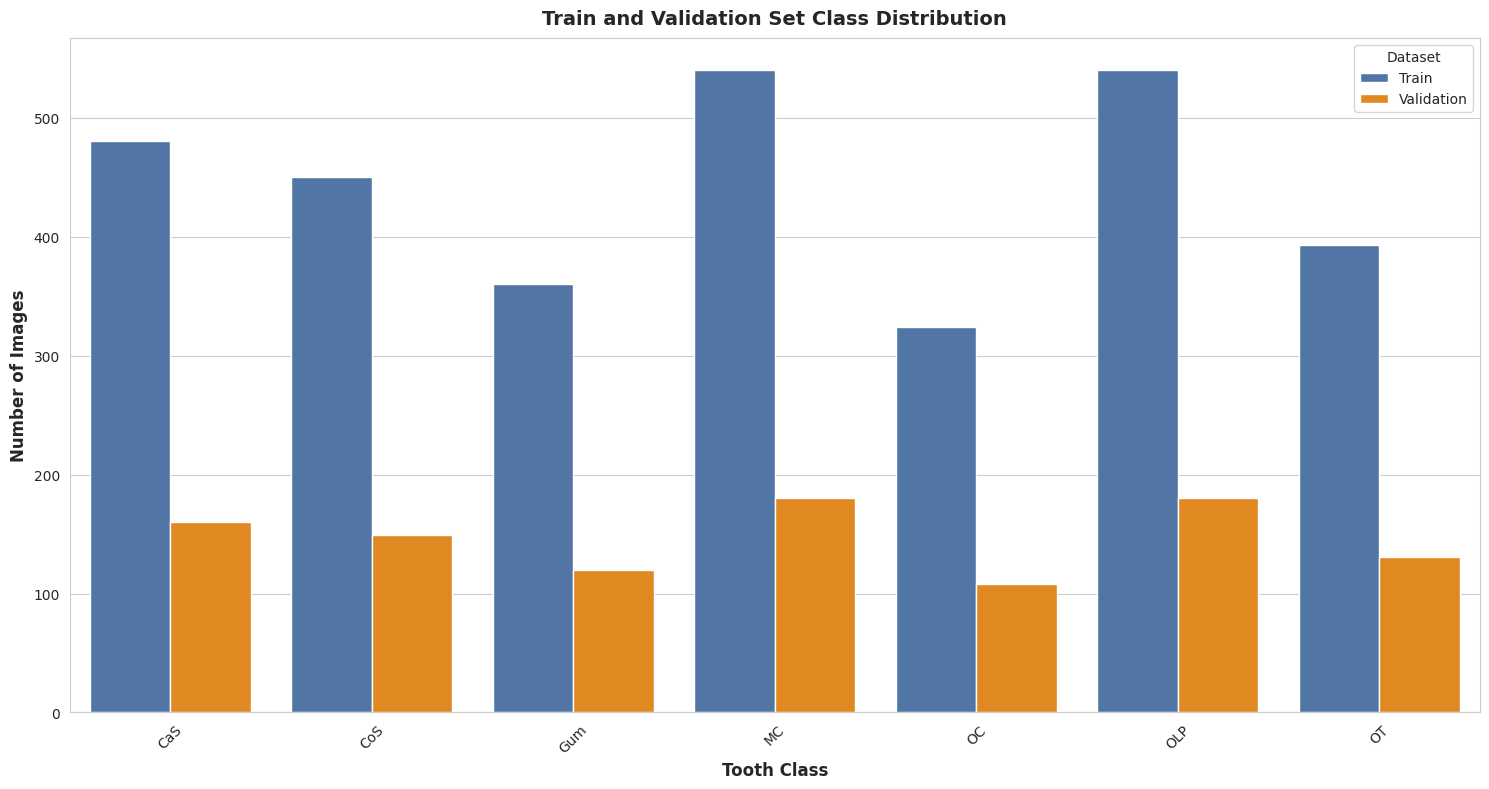

In [ ]:
def get_class_distribution(directory):
    """Counts the number of images in each class subdirectory."""
    class_counts = {}
    # Assuming class names are the names of the subdirectories
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        num_files = len(os.listdir(class_path))
        class_counts[class_name] = num_files
    return class_counts

# Get the distributions for only train and validation sets
train_counts = get_class_distribution(train_dir)
validation_counts = get_class_distribution(validation_dir)
# We are intentionally not calculating test_counts for this visualization

# Get class names from the training directory
class_names = list(train_counts.keys())
print(f"Found {len(class_names)} classes: {class_names}\n")

# Prepare data for plotting (only train and validation)
plot_data = {
    'Class': class_names * 2,
    'Count': list(train_counts.values()) + list(validation_counts.values()),
    'Set': ['Train'] * len(class_names) + ['Validation'] * len(class_names)
}

import pandas as pd
df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Class', y='Count', hue='Set', data=df, palette=['#4374B3', '#FF8C00']) # Using custom colors for clarity
plt.title('Train and Validation Set Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Tooth Class')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()

In [ ]:
# Define image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 1. ImageDataGenerator for the Training Set (with Augmentation)
print("Defining Training Data Generator with Augmentation...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. ImageDataGenerator for the Validation and Test Sets (only Normalization)
print("Defining Validation/Test Data Generator (Normalization only)...")
val_test_datagen = ImageDataGenerator(rescale=1./255)

Defining Training Data Generator with Augmentation...
Defining Validation/Test Data Generator (Normalization only)...


In [ ]:
print("Creating data generators from directories...")

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    shuffle=True
)

# Validation data generator
validation_generator = val_test_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle test data
)

# You can check the class indices that Keras assigned
print("\nClass Indices assigned by the generator:")
print(train_generator.class_indices)

Creating data generators from directories...
Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.

Class Indices assigned by the generator:
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


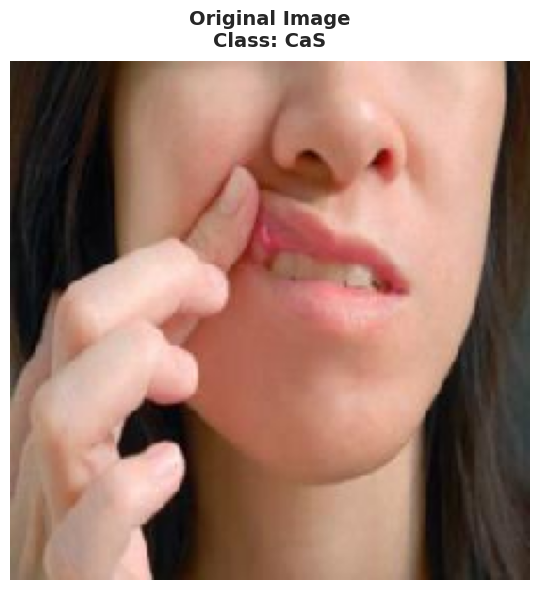

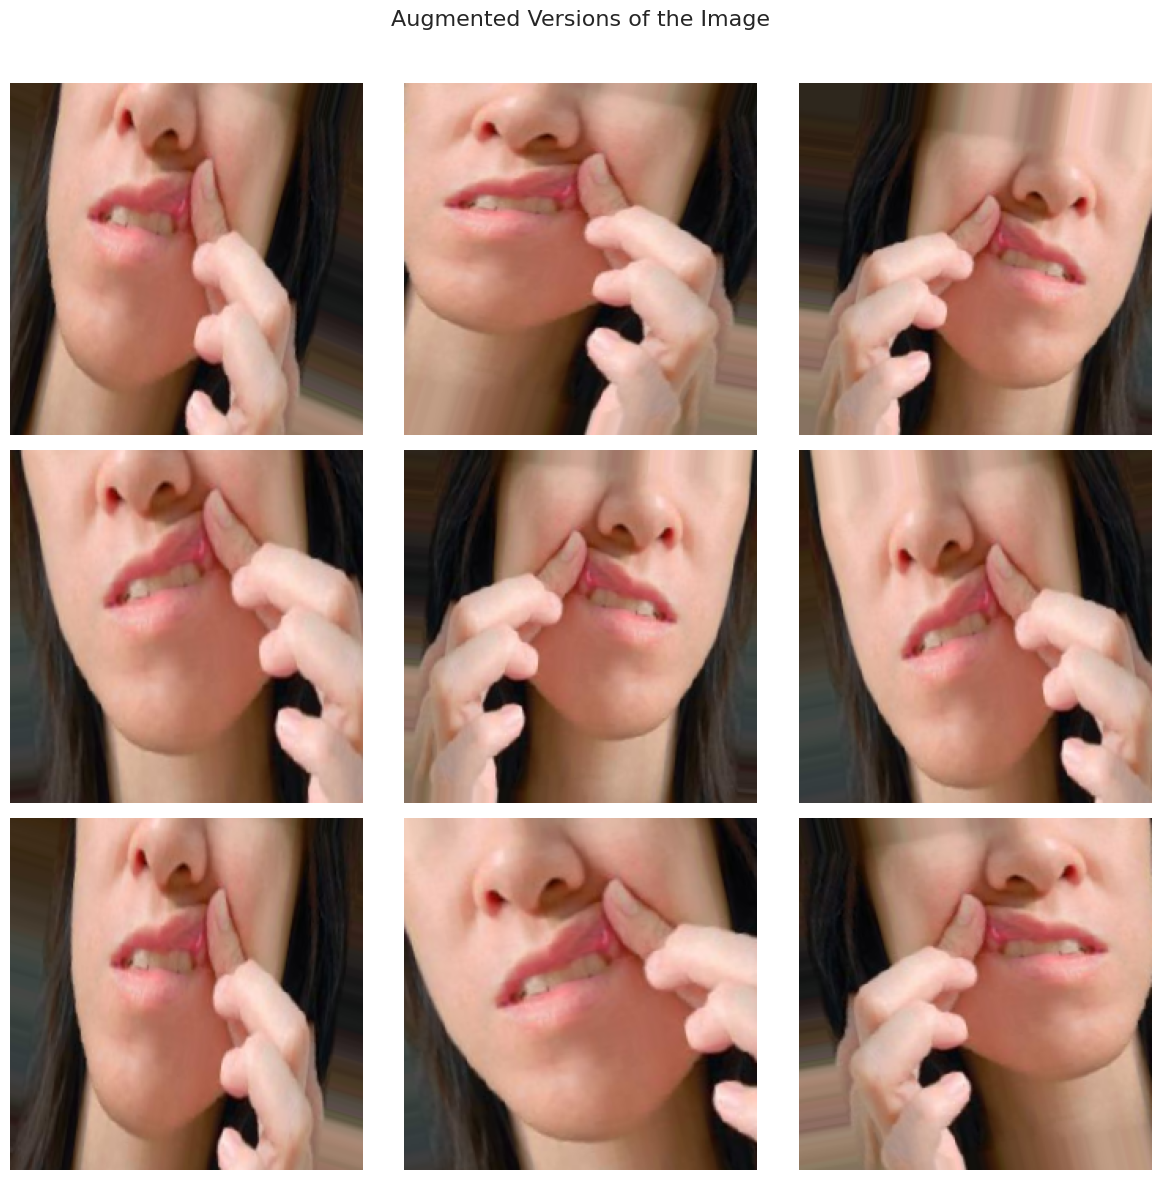

In [ ]:
# Get the first class name from the training directory
first_class_name = class_names[0]
sample_image_dir = os.path.join(train_dir, first_class_name)
sample_image_name = os.listdir(sample_image_dir)[0] # Get the first image
sample_image_path = os.path.join(sample_image_dir, sample_image_name)

# Load the sample image
sample_img = load_img(sample_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
sample_img_array = img_to_array(sample_img)
# Reshape to (1, height, width, channels) to be used by the generator
sample_img_array = np.expand_dims(sample_img_array, axis=0)

# --- 1. Display the Original Image ---
plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.title(f"Original Image\nClass: {first_class_name}")
plt.axis('off')
plt.show()


# --- 2. Display Augmented Images ---
# Generate a batch of augmented images from our single sample image
augmentation_iterator = train_datagen.flow(sample_img_array, batch_size=1)

plt.figure(figsize=(12, 12))
plt.suptitle(f"Augmented Versions of the Image", fontsize=16)

# Generate and plot 9 augmented images
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_img_batch = next(augmentation_iterator)
    # The generator normalizes the image (rescale=1./255), so we see it as float [0,1]
    augmented_img = augmented_img_batch[0]
    plt.imshow(augmented_img)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

# Retrieve the number of classes from the generator (should be 7)
num_classes = len(train_generator.class_indices)

model = Sequential([

    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),

    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),

    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),

    MaxPooling2D((2, 2)),

    Flatten(),


    Dense(128, activation='relu'),

    Dropout(0.5),


    Dense(num_classes, activation='softmax')
])

# Print the model's architecture. Pay attention to how the output shape changes after each layer.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,335 (49.36 MB)

 Trainable params: 12,939,335 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os


base_dir1 = '/content/drive/MyDrive/Teeth-Classification'
save_dir = os.path.join(base_dir1, 'saved_models')
os.makedirs(save_dir, exist_ok=True)
model_filepath = os.path.join(save_dir, 'best_baseline_model.keras')

# --- 2. CONFIGURE THE CALLBACKS ---

# ModelCheckpoint: Save the best model seen so far.
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stop training when the model stops improving.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=0.00001
)

# You can now put all your desired callbacks into a list.
callbacks_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

print("Callbacks configured successfully!")
print(f"Best model will be saved to: {model_filepath}")

Callbacks configured successfully!
Best model will be saved to: /content/drive/MyDrive/Teeth-Classification/saved_models/best_baseline_model.keras


In [ ]:
# We can set a higher number of epochs because EarlyStopping will handle stopping the training.
EPOCHS = 50

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    # Pass the list of all our configured callbacks here
    callbacks=callbacks_list
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.1389 - loss: 2.4734 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.17704, saving model to /content/drive/MyDrive/Teeth-Classification/saved_models/best_baseline_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1786s 18s/step - accuracy: 0.1391 - loss: 2.4693 - val_accuracy: 0.1770 - val_loss: 1.9146 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.2084 - loss: 1.9038
Epoch 2: val_accuracy improved from 0.17704 to 0.27724, saving model to /content/drive/MyDrive/Teeth-Classification/saved_models/best_baseline_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 541ms/step - accuracy: 0.2085 - loss: 1.9036 - val_accuracy: 0.2772 - val_loss: 1.7675 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.2706 - loss: 1.8174
Epoch 3: val_accuracy improved from 0.27724 to 0.33949, saving model to /content/drive/MyDrive/Teeth-Classification/saved_models/best_baseline_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 577ms/step - accuracy: 0.2706 - loss: 1.8174 - val

In [ ]:
from tensorflow.keras.models import load_model

# The path should be the same one we defined for our ModelCheckpoint callback
model_filepath = os.path.join(save_dir, 'best_baseline_model.keras')

# Load the saved model
print(f"Loading the best model from: {model_filepath}")
best_model = load_model(model_filepath)
print("Model loaded successfully!")

Loading the best model from: /content/drive/MyDrive/Teeth-Classification/saved_models/best_baseline_model.keras
Model loaded successfully!


33/33 ━━━━━━━━━━━━━━━━━━━━ 305s 9s/step

Classification Report:

              precision    recall  f1-score   support

         CaS       0.87      0.84      0.85       160
         CoS       0.93      0.94      0.93       149
         Gum       0.95      0.88      0.91       120
          MC       0.84      0.92      0.88       180
          OC       0.84      0.85      0.84       108
         OLP       0.83      0.87      0.85       180
          OT       0.95      0.85      0.90       131

    accuracy                           0.88      1028
   macro avg       0.89      0.88      0.88      1028
weighted avg       0.88      0.88      0.88      1028


Confusion Matrix:



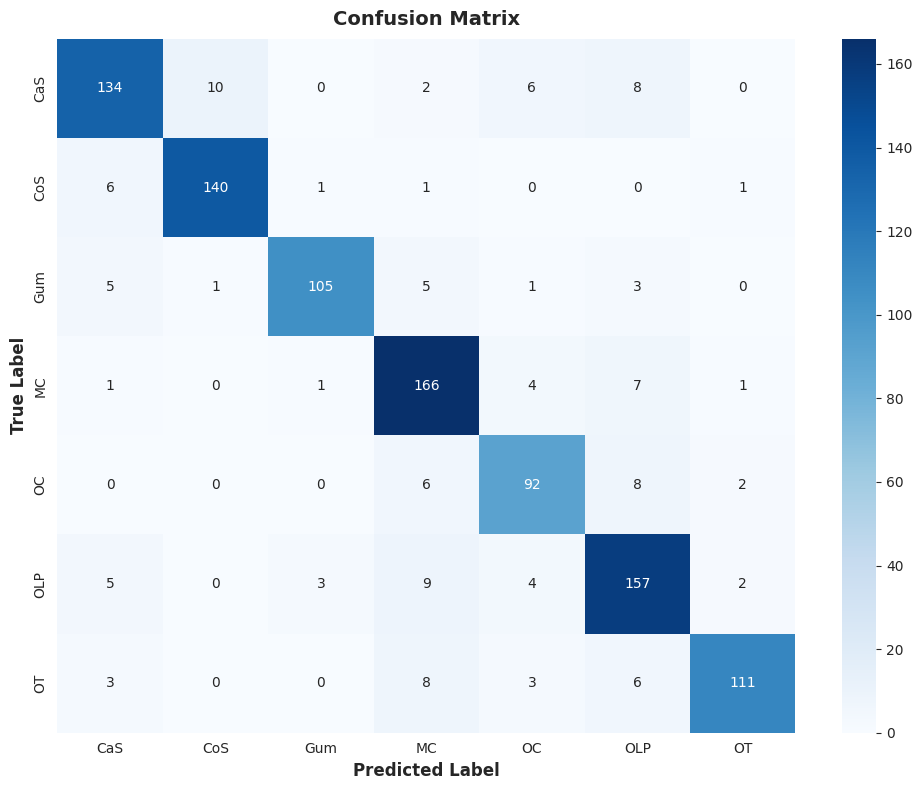

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Get Predictions
y_pred_probs = best_model.predict(test_generator)

y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels

y_true = test_generator.classes

# 3. Get Class Names

class_names = list(test_generator.class_indices.keys())

# --- CLASSIFICATION REPORT ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# --- CONFUSION MATRIX ---
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()